## Project description

This analysis was a part of my research project on idenfifying non-coding genetic polymorphysms responsible for human autoimmune diseases. We observed a dramatic drop in the IKZF3 gene expression* after genome editing, even in cells with the same genotype as the parent cell line. So we looked into whether the cause might be in epigenetics (namely DNA methylation).

This notebook was utilized to:
+ Study the effect of our CRISPR-Cas9 genome editing procedure on DNA methylation levels near the editing site.
+ Look for any correlation between DNA methylation and IKZF3 expression.

After bisulfite conversion of total genomic DNA isolated from several cell clones of each genotype and editing stage, a CpG island (CGI) and 2 hypomethylated DNA regions (HMRs) near the genome editing site were amplyfied using a panel of primers, and sequenced at the Illumina MiSeq Instrument. Methylation levels at each CpG** were compared among two genetically modified cell lines, the parent wild-type line, and primary CD4 T-lymphocytes (external data). The raw sequencing data was processed by my collaborator Ekaterina M. Dvorianinova to produce the starting dataset.

More information can be found in the [publication](https://www.researchgate.net/profile/Alina-Ustiugova/publication/365738937_CRISPRCas9_genome_editing_demonstrates_functionality_of_the_autoimmunity-associated_SNP_rs12946510/links/64229cb892cfd54f84335e08/CRISPR-Cas9-genome-editing-demonstrates-functionality-of-the-autoimmunity-associated-SNP-rs12946510.pdf?origin=journalDetail&_tp=eyJwYWdlIjoiam91cm5hbERldGFpbCJ9).

\* Expression level (mRNA quantity) determins, along with other factors, how much of the corresponding protein is going to be produced by the cell.

\** In human cells, DNA methylation normally occurs at cytosines (C) immediately followed by a guanine (G). This mofit is referred to as CpG. Cytosines can also be methylated in other contexts, however this is only found in [specific cell types](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5485512/).

In [ ]:
import numpy as np
from scipy import stats
import pandas as pd
import os
import re

from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
# Construct a sequencing data table from the preprocessed data
dir = 'covGz'
primers = os.listdir(dir) # each primer pair correspond to its own chromosome region
primers.remove('.DS_Store')

meth_all = pd.DataFrame()
for pr in primers:
    path = os.path.join(dir, pr)
    files = os.listdir(path)
    files.remove('.DS_Store')
    for i in files:
        df = pd.read_csv(dir+'/'+pr+'/'+i, sep='\t', header=None,
                         names = ['Chromosome', 'Start', 'End',
                                  'Methylation_Percentage',
                                  'Count_Methylated',
                                  'Count_Unmethylated'])

        # Calculate the sequencing coverage at each CpG
        df['total_count'] = df.Count_Methylated + df.Count_Unmethylated
        df['Clone'] = i.split('_')[0]
        meth_all = pd.concat((meth_all, df))

# Mark experimental groups
meth_all['Group'] = 'Edited'
meth_all.loc[meth_all.Clone.isin(['II-22','II-23','II-31','II-32']),
             'Group'] = 'dTomato'
meth_all.loc[meth_all.Clone.isin(['Wc2','Wc3','Wc4','Wc5']),'Group'] = 'WT'
meth_all.loc[meth_all.Clone=='metJ','Group'] = 'Positive_control'
meth_all

,Chromosome,Start,End,Methylation_Percentage,Count_Methylated,Count_Unmethylated,total_count,Clone,Group
0,17,39753836,39753836,0.000000,0,1,1,ZB13,Edited
1,17,39753845,39753845,0.000000,0,1,1,ZB13,Edited
2,17,39753856,39753856,0.000000,0,1,1,ZB13,Edited
3,17,39753866,39753866,0.000000,0,1,1,ZB13,Edited
4,17,39753878,39753878,0.000000,0,1,1,ZB13,Edited
...,...,...,...,...,...,...,...,...,...
33,17,39756006,39756006,1.503759,4,262,266,ZB13,Edited
34,17,39756074,39756074,12.820513,10,68,78,ZB13,Edited
35,17,39756149,39756149,7.407407,4,50,54,ZB13,Edited
36,17,65136084,65136084,16.000000,4,21,25,ZB13,Edited


### Sequencing data table description

Each row represent a single CpG location present in the sequencing reads
- **Chromosome**, **Start**, **End**: genomic coordinate of a CpG according to the mapping of the sequencing reads on hg38
- **Methylation_Percentage**: the percentage of reads that contained sequence variant corresponding to methylated CpG
- **Count_Methylated**, **Count_Unmethylated**: the number of reads containing methylated and unmethylated sequence variants
- **total_count**: the total number of sequence reads containing the corresponding CpG
- **Clone**: cell clone or fully methylated DNA preparation (positive control), from which the reads were obtained
- **Group**: experimental group (parent cell line clones, intermediate genome editing stage clones, fully edited clones, or positive control)

In [ ]:
# Unify the datatype for all chromosome names
# and check to which chromosomes the reads were mapped
meth_all = meth_all.astype({'Chromosome':'str'}, copy=False)
meth_all.groupby('Chromosome').total_count.sum()

# Most of the reads are expected to be on the chromosome 17 near the editing site

Chromosome
1        831
10       158
11        60
12       133
13        38
14        12
15        39
16       125
17    363545
18        94
19       116
2        364
20        30
21        10
22        52
3        564
4         70
5        126
6         40
7        150
8        293
9        163
X         80
Name: total_count, dtype: int64

The genome editing site was located on the 17th chromosome. Other minor reads come from non-specific amplification during the sequencing library preparation.

In [ ]:
# Add a dataset covering problematic segments,
# which was obtained using different criteria at the preprocessing stage
meth_trim28 = pd.read_csv('meth.csv')
meth_trim28 = meth_trim28.astype({'Chromosome':'str'})
meth_trim28

,Chromosome,Start,End,Methylation_Percentage,Count_Methylated,Count_Unmethylated,total_count,Clone,Group
0,17,39753836,39753836,0.000000,0,591,591,II-23,dTomato
1,17,39753845,39753845,0.000000,0,591,591,II-23,dTomato
2,17,39753856,39753856,0.000000,0,591,591,II-23,dTomato
3,17,39753866,39753866,0.507614,3,588,591,II-23,dTomato
4,17,39753878,39753878,0.169492,1,589,590,II-23,dTomato
...,...,...,...,...,...,...,...,...,...
1407,17,73254800,73254800,98.913043,91,1,92,metJ,Positive_control
1408,17,73254877,73254877,100.000000,92,0,92,metJ,Positive_control
1409,17,73254884,73254884,100.000000,92,0,92,metJ,Positive_control
1410,17,73254933,73254933,100.000000,90,0,90,metJ,Positive_control


In [ ]:
# For each CpG we keep the data from a dataset, that contains more reads
meth = pd.concat((meth17, meth_trim28))

# Keep only relevant chromosome region
meth = meth[(meth.End >= 39753786)&(meth.End <= 39758787)].copy()
meth.sort_values(by=['End', 'total_count'], inplace=True)
meth.drop_duplicates(subset=['End','Clone'], keep='last', inplace=True)
meth

,Chromosome,Start,End,Methylation_Percentage,Count_Methylated,Count_Unmethylated,total_count,Clone,Group
1312,17,39753836,39753836,98.492462,392,6,398,metJ,Positive_control
212,17,39753836,39753836,0.187970,1,531,532,II-22,dTomato
0,17,39753836,39753836,0.000000,0,591,591,II-23,dTomato
85,17,39753836,39753836,0.000000,0,666,666,XA33,Edited
483,17,39753836,39753836,0.149925,1,666,667,XA26,Edited
...,...,...,...,...,...,...,...,...,...
296,17,39758737,39758737,91.601050,349,32,381,II-22,dTomato
1105,17,39758737,39758737,85.049020,347,61,408,II-32,dTomato
182,17,39758737,39758737,93.246187,428,31,459,XA33,Edited
1209,17,39758737,39758737,49.345794,264,271,535,Wc5,WT


In [ ]:
# Load real-time PCR data on the IKZF3 mRNA levels in individual clones.
# mRNA level is normalized to the average of the wild type clones.
ik3expr = pd.read_csv('ikzf3expr.csv')

# Merge it with the sequencing data
meth = meth.merge(ik3expr, on='Clone', how='left')
meth

,Chromosome,Start,End,Methylation_Percentage,Count_Methylated,Count_Unmethylated,total_count,Clone,Group,IKZF3
0,17,39753836,39753836,98.492462,392,6,398,metJ,Positive_control,NaN
1,17,39753836,39753836,0.187970,1,531,532,II-22,dTomato,0.481370
2,17,39753836,39753836,0.000000,0,591,591,II-23,dTomato,0.330047
3,17,39753836,39753836,0.000000,0,666,666,XA33,Edited,0.000762
4,17,39753836,39753836,0.149925,1,666,667,XA26,Edited,0.297339
...,...,...,...,...,...,...,...,...,...,...
2176,17,39758737,39758737,91.601050,349,32,381,II-22,dTomato,0.481370
2177,17,39758737,39758737,85.049020,347,61,408,II-32,dTomato,0.407123
2178,17,39758737,39758737,93.246187,428,31,459,XA33,Edited,0.000762
2179,17,39758737,39758737,49.345794,264,271,535,Wc5,WT,1.591913


Genomic coordinates (hg38 assembly) of the three regions of interest (ROIs) are:
+ CpG Island: chr17:39753786-39755200
+ 510Enh HMR: chr17:39755535-39756560
+ IKZF3 HMR: chr17:39757881-39758787

In [ ]:
# Save them as numeric variables
cgi_start = 39753786
cgi_end = 39755200
enh510_start = 39755535
enh510_end = 39756560
ikzf_start = 39757881
ikzf_end = 39758787

In [ ]:
# Extract data for each of the three ROIs and keep only datapoints with 10 or more reads
Enh510_HMR = meth[(meth.End >= enh510_start)&(meth.End <= enh510_end)]
Enh510_HMR = Enh510_HMR[Enh510_HMR.total_count > 9]
CGI = meth[(meth.End >= cgi_start)&(meth.End <= cgi_end)]
CGI = CGI[CGI.total_count > 9].copy()
IKZF3_HMR = meth[(meth.End >= ikzf_start)&(meth.End <= ikzf_end)]
IKZF3_HMR = IKZF3_HMR[IKZF3_HMR.total_count > 9].copy()

### Coverage and methylation levels
with a clone resolution across all three ROIs in chromosomal coordinates

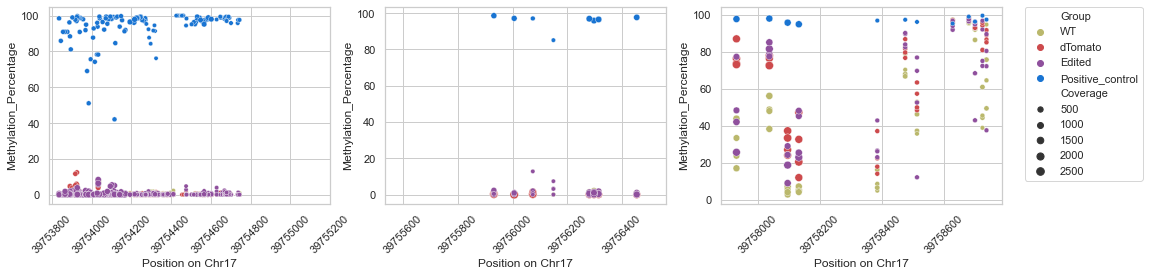

In [ ]:
# Visualize the sequencing coverage and methylation levels across all ROIs at the clone level

# Prepare the data
coverage = {}
for i, df in enumerate([CGI, Enh510_HMR, IKZF3_HMR]):
    df.Group = pd.Categorical(df.Group,
        categories=['WT', 'dTomato', 'Edited', 'Positive_control'])
    df = df.sort_values('Group')

    # These clones have a different genotype and are not included
    coverage[i] = df[~df.Clone.isin(['XA26','XA33'])].copy()
    coverage[i].rename(columns={'total_count':'Coverage'}, inplace=True)

# Plot it
f, axs = plt.subplots(1, 3, figsize=(16, 4))
sns.set_theme(style="whitegrid", palette=c6)
for i in range(2):
    sns.scatterplot(x='End', y='Methylation_Percentage', hue='Group',
                    size='Coverage', data=coverage[i],
                    size_norm=(10,3138), legend=False, ax=axs[i])

sns.scatterplot(x='End', y='Methylation_Percentage', hue='Group',
                size='Coverage', data=coverage[2],
                size_norm=(10,3138), legend='brief', ax=axs[2])

plt.legend(bbox_to_anchor=(1.5, 1), loc='upper right', borderaxespad=0)

axs[0].set_xlim(left=cgi_start, right=cgi_end)
axs[1].set_xlim(left=enh510_start, right=enh510_end)
axs[2].set_xlim(left=ikzf_start, right=ikzf_end)

for i in axs:
    i.set(xlabel='Position on Chr17')
    i.tick_params(axis='x', labelrotation=45)
    i.ticklabel_format(style='plain', useOffset=False, axis='x')
f.tight_layout()
#plt.savefig('NGS_coverage_trim20.png', dpi=300, bbox_inches='tight', edgecolor='white', transparent=True)

Not the entire span of CGI and HMR could be successfully amlified and sequenced, but the available data is sufficient for our purposes. Luckily, the most interesting and important region (IKZF3 3'-UTR HMR) was sequenced in full.

### Bisulfite conversion rate
In lymphocytes, non-CpG cytosines are not expected to me methylated. If conversion is complete, they should be read as thymines. The ratio of T-reads to C-reads at non-CpG cytosines helps us estimate the conversion rate.

In [ ]:
# Import and combine data on non-CpG cytosines
# "H" is the IUPAC code for A or C or T
chh = pd.read_csv('CHH_17_conversion_aggr.csv', index_col=0)
chh['context'] = 'CHH'
chg = pd.read_csv('CHG_17_conversion_aggr.csv', index_col=0)
chh['context'] = 'CHG'
conv = pd.concat([chh,chg], ignore_index=True)

# Add information on experimental groups
conv['Group'] = 'Edited'
conv.loc[conv.Clone.isin(['II-22','II-23','II-31','II-32']),'Group'] = 'dTomato'
conv.loc[conv.Clone.isin(['Wc2','Wc3','Wc4','Wc5']),'Group'] = 'WT'
conv.loc[conv.Clone == 'metJ', 'Group'] = 'Positive_control'

# We concider coverage informative if the number of reads is 10 or above
conv10 = conv[conv['N reads'] > 9].copy()
conv10.describe()

,chr,pos,N reads,N unconverted,% unconverted,%_conversion
count,5708.0,5.708000e+03,5708.000000,5708.000000,5708.000000,5708.000000
mean,17.0,3.975644e+07,809.468991,1.004555,0.692096,99.307904
std,0.0,1.757104e+03,889.212540,2.457556,2.915607,2.915607
min,17.0,3.975383e+07,10.000000,0.000000,0.000000,70.370370
25%,17.0,3.975468e+07,54.000000,0.000000,0.000000,99.911972
50%,17.0,3.975636e+07,398.000000,0.000000,0.000000,100.000000
75%,17.0,3.975813e+07,1280.000000,1.000000,0.088028,100.000000
max,17.0,3.975875e+07,3141.000000,30.000000,29.629630,100.000000


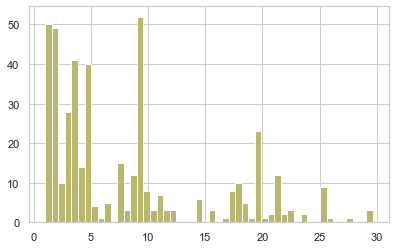

In [ ]:
# See how % of unconverted cytosines is distributed (for those > 1%)

f2 = plt.figure(figsize=(5,3))
a2 = f2.add_axes([0, 0, 1, 1])
conv10.loc[conv10['% unconverted'] > 1,'% unconverted'].hist(bins=50)
f.tight_layout()

Visualize conversion across our ROIs

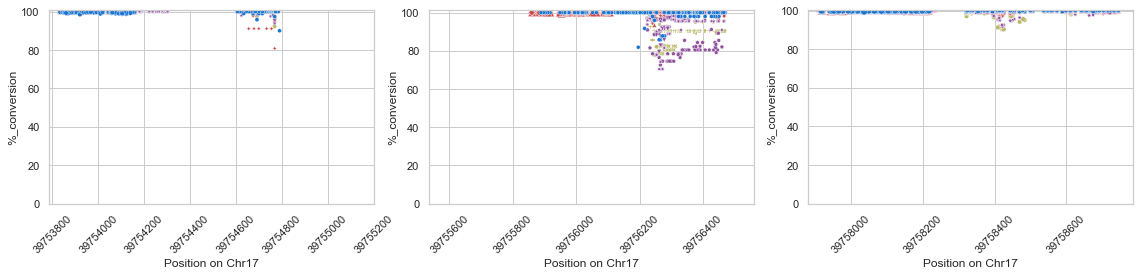

In [ ]:
# Prepare the data
CGI_conv = conv10[(conv10.pos >= cgi_start)&(conv10.pos <= cgi_end)]
Enh510_conv = conv10[(conv10.pos >= enh510_start)&(conv10.pos <= enh510_end)]
IKZF3_conv = conv10[(conv10.pos >= ikzf_start)&(conv10.pos <= ikzf_end)]

conv_dict={}
for i, df in enumerate([CGI_conv, Enh510_conv, IKZF3_conv]):
    df.Group = pd.Categorical(df.Group,categories=
        ['WT', 'dTomato', 'Edited', 'Positive_control'])
    df = df.sort_values('Group')
    conv_dict[i] = df

# Plot it
f, axs = plt.subplots(1, 3, figsize=(16, 4))
sns.set_theme(style="whitegrid", palette=c6)
for i in range(3):
    sns.scatterplot(x='pos', y='%_conversion', hue='Group', size='N reads',
                    style='Clone', data=conv_dict[i],
                    size_norm=(10,3141), legend=False, ax=axs[i])
plt.setp(axs, yticks=range(0,101,20))
axs[0].set_xlim(left=cgi_start, right=cgi_end)
axs[1].set_xlim(left=enh510_start, right=enh510_end)
axs[2].set_xlim(left=ikzf_start, right=ikzf_end)

for i in axs:
    i.set(xlabel='Position on Chr17')
    i.tick_params(axis='x', labelrotation=45)
    i.ticklabel_format(style='plain', useOffset=False, axis='x')
f.tight_layout()
#plt.savefig('NGS_conversion.png', dpi=300, bbox_inches='tight', edgecolor='white')

Conversion was overall succesfull. It could be incomplete  around Enh510 HMR for some clones, but this is most probably an arfifact, as it is restricted to a particular primer pair.

## DNA methylation at different editing stages

### CGI

In [ ]:
# Import the CGI DNA sequence
with open('cgi_dna.txt', 'r') as f:
    cgi_dna = f.read().rstrip()

# Locate the CpGs
cgi_cpgs = re.finditer('CG', cgi_dna)
CGI_CpGs = []
for i in cgi_cpgs:
    CGI_CpGs.append(i.start())
CGI_CpG_positions_hg38 = [x + cgi_start for x in CGI_CpGs]

In [ ]:
# Check the sequencing coverage at each CpG in each clone
CGI_CpG_number = pd.DataFrame({'End':CGI_CpG_positions_hg38,
    'CpG_number':range(1,(len(CGI_CpG_positions_hg38)+1))})
CGI = CGI.merge(CGI_CpG_number, how='left', on='End')
CGI_pivot = CGI.pivot(index='CpG_number', columns='Clone', values='total_count')
CGI_pivot

Clone,II-22,II-23,II-31,II-32,Wc2,Wc3,Wc4,Wc5,XA26,XA33,ZA38,ZB10,ZB13,ZB17,metJ
CpG_number,,,,,,,,,,,,,,,
1,532.0,591.0,729.0,730.0,1197.0,970.0,1136.0,1182.0,667.0,666.0,1003.0,1260.0,1279.0,1061.0,398.0
2,532.0,591.0,729.0,730.0,1197.0,970.0,1136.0,1183.0,668.0,666.0,1003.0,1260.0,1280.0,1061.0,398.0
3,532.0,591.0,729.0,729.0,1197.0,970.0,1136.0,1183.0,668.0,666.0,1003.0,1260.0,1280.0,1062.0,398.0
4,532.0,591.0,729.0,730.0,1197.0,969.0,1136.0,1183.0,668.0,666.0,1003.0,1260.0,1280.0,1062.0,398.0
5,531.0,590.0,729.0,730.0,1196.0,969.0,1134.0,1183.0,667.0,666.0,1003.0,1260.0,1280.0,1061.0,398.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,82.0,81.0,73.0,88.0,114.0,81.0,64.0,57.0,72.0,70.0,86.0,61.0,83.0,74.0,169.0
121,82.0,81.0,72.0,88.0,114.0,81.0,64.0,57.0,72.0,69.0,85.0,61.0,83.0,74.0,169.0
122,81.0,82.0,73.0,88.0,113.0,81.0,63.0,57.0,72.0,70.0,86.0,62.0,83.0,74.0,169.0


CpG location relative to PCR products:

|CpG #|Primer pair (PCR product)|
|-----|-------------------------|
|1-51|CGI4|
|52-109|mm2 (CpG#110 is in the mm2 primer itself)
|110-124|CGI1|
|125-154|CGI5c|

<AxesSubplot:title={'center':'CGI CpG coverage'}, xlabel='Clone', ylabel='CpG_number'>

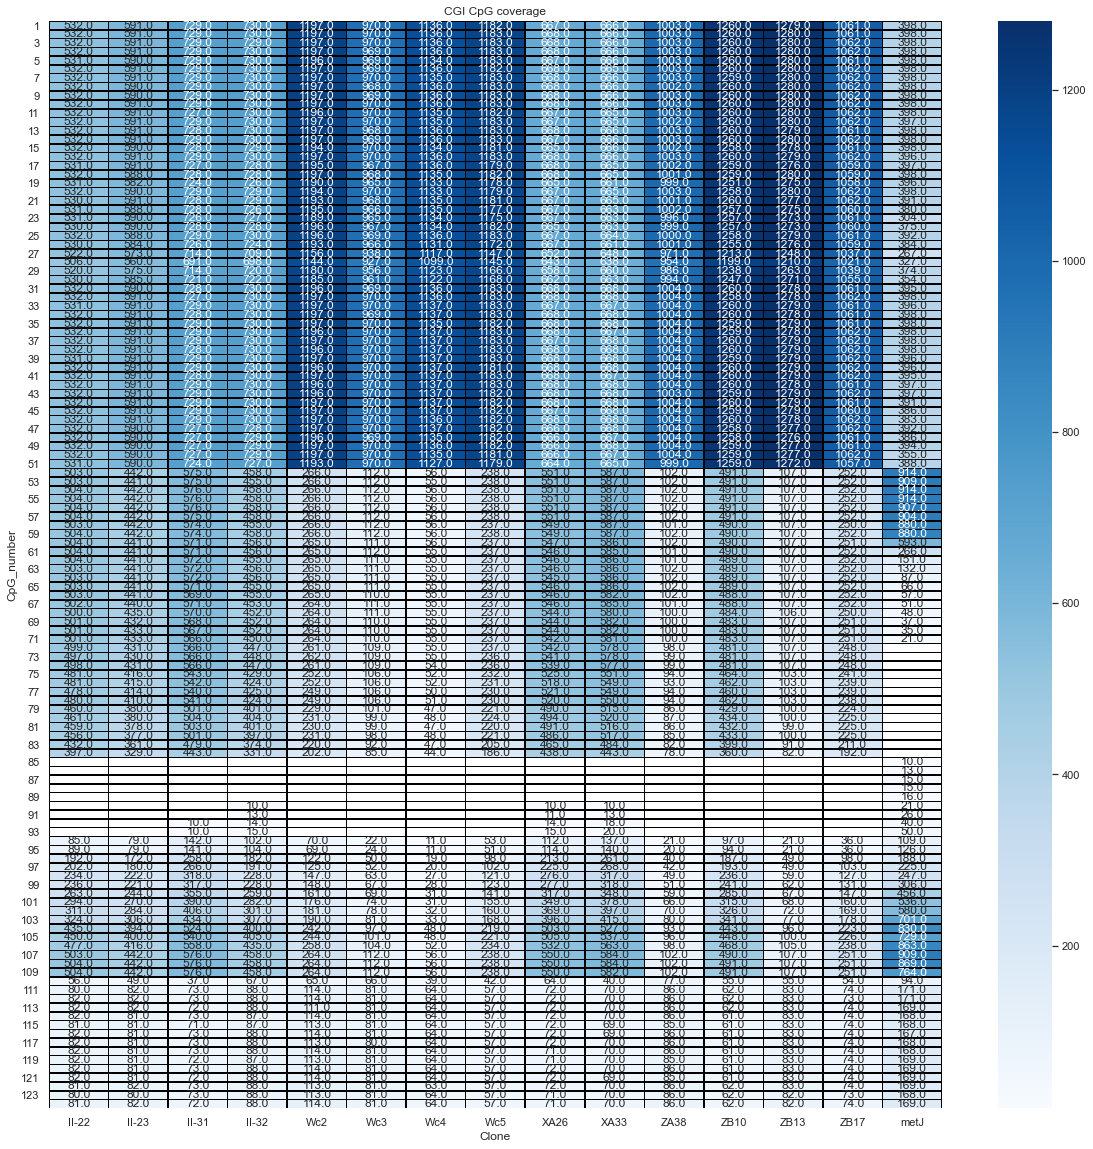

In [ ]:
# Visualize the coverage to check for data availability and quality
sns.set(style='white')
plt.figure(figsize=(20, 20))
plt.title('CGI CpG coverage')
sns.heatmap(CGI_pivot, mask=CGI_pivot.isnull(), annot=True, fmt='0000',
            linewidths=0.5, linecolor='black', cmap="Blues")
#plt.savefig('CGI_coverage.png', dpi=300, bbox_inches='tight', edgecolor='white')

In [ ]:
# Create the color palettes for various article figures
c2=sns.crayon_palette(['Mahogany','Vivid Violet','Dandelion','Navy Blue'])
c3=sns.crayon_palette(['Mahogany','Vivid Violet','Olive Green','Navy Blue'])
c4=sns.crayon_palette(['Vivid Violet','Dandelion','Navy Blue'])
c5=sns.crayon_palette(['Vivid Violet','Olive Green','Navy Blue'])
c6=sns.crayon_palette(['Olive Green','Mahogany','Vivid Violet','Navy Blue'])

Visulaize data for the high-coverage CGI region

In [ ]:
# Remove the data from non-relevant clones
CGI_fig = CGI[~CGI.Clone.isin(['metJ','XA26','XA33'])].copy()

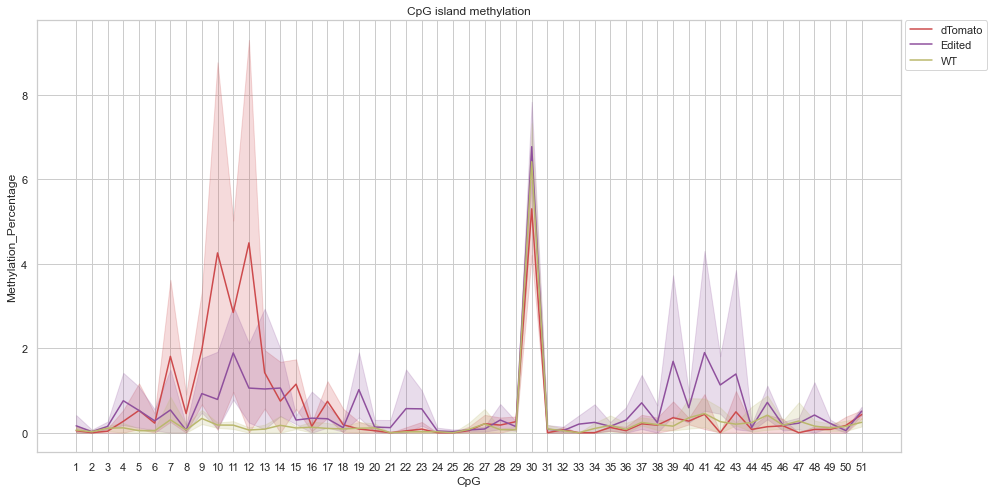

In [ ]:
# Visualize and compare methylation levels at the CGI of parental cell line (WT),
# first editing step (dTomato), and fully edited clones (Edited).

# Lines represent average across clones.
# Transparent color bands represent standard deviation.

f2 = plt.figure(figsize=(12,6))
a2 = f2.add_axes([0, 0, 1, 1])
sns.set_theme(style="whitegrid", palette=c3)
sns.lineplot(x="CpG_number", y="Methylation_Percentage",
             hue="Group", data=CGI_fig)
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper right', borderaxespad=0)
plt.xticks(range(1,52))
a2.set(title='CpG island methylation', xlabel='CpG')
#plt.savefig('CGI_Methylation.png', dpi=300, bbox_inches='tight', edgecolor='white')

Visulaize data for the entire CGI region

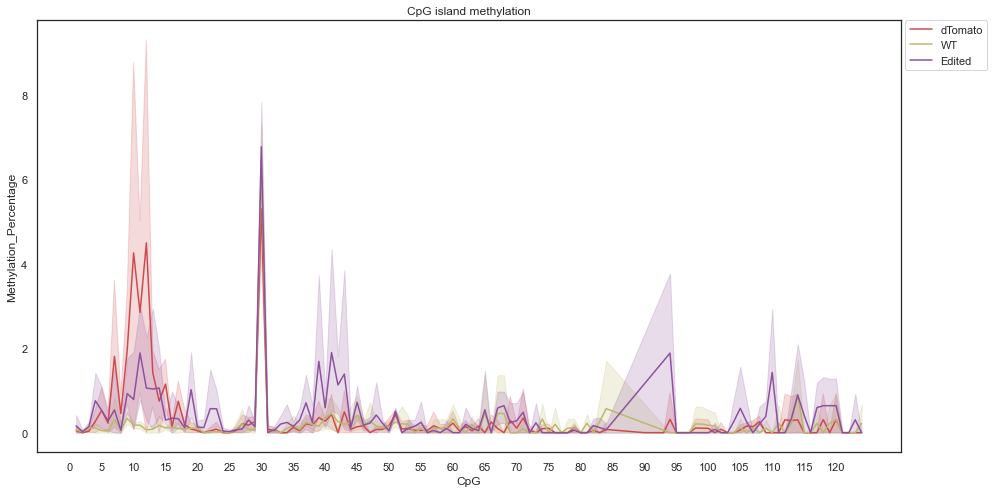

In [ ]:
f2 = plt.figure(figsize=(12,6))
a2 = f2.add_axes([0, 0, 1, 1])
sns.set_theme(style="whitegrid", palette=[c3[0],c3[2],c3[1]])
sns.lineplot(x="CpG_number", y="Methylation_Percentage",
             hue="Group", data=CGI_fig)
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper right', borderaxespad=0)
plt.xticks(range(0,125,5))
a2.set(title='CpG island methylation', xlabel='CpG')
#plt.savefig('CGI_Methylation_all.png', dpi=300, bbox_inches='tight', edgecolor='white')

In [ ]:
# Check if the difference in average methylation level across all CpGs between
# the parental clones and the fully edited clones is statistically significant

CGImean = CGIstat.groupby(by=['Group','Clone'],
    as_index=False)['Methylation_Percentage'].mean()
CGImean = CGImean[~CGImean.Methylation_Percentage.isna()]
stats.mannwhitneyu(x=CGImean[CGImean.Group=='Edited'].Methylation_Percentage,
                   y=CGImean[CGImean.Group=='WT'].Methylation_Percentage,
                   alternative='greater')

MannwhitneyuResult(statistic=16.0, pvalue=0.015191410988288745)

In [ ]:
stats.mannwhitneyu(x=CGImean[CGImean.Group=='dTomato'].Methylation_Percentage,
                   y=CGImean[CGImean.Group=='WT'].Methylation_Percentage, alternative='greater')

MannwhitneyuResult(statistic=12.0, pvalue=0.156160710838108)

**Although the average methylation levels are higher in the edited cells, the overall methylation of the region is so low that its changes cannot explain the observed several-fold expression drop in the IKZF3 expression.**

### HMR 510
(hypomethylated region overlapping the editing site)

In [ ]:
# Import the DNA sequence of the HMR overlapping the editing site
with open('hmr510.txt', 'r') as f:
    hmr510 = f.read().rstrip()

# Locate the CpGs
hmr510_cpgs = re.finditer('CG', hmr510_dna)
HMR510_CpGs = []
for i in hmr510_cpgs:
    HMR510_CpGs.append(i.start())
HMR510_CpG_positions_hg38 = [x+enh510_start for x in HMR510_CpGs]

In [ ]:
# Check the sequencing coverage at each CpG in each clone
Enh510_HMR_number = pd.DataFrame({'End':HMR510_CpG_positions_hg38,
    'CpG_number':range(1,(len(HMR510_CpG_positions_hg38)+1))})
Enh510_HMR = Enh510_HMR.merge(Enh510_HMR_number, how='left', on='End')
Enh510_HMR_pivot = Enh510_HMR.pivot(index='CpG_number',
    columns='Clone', values='total_count')

In [ ]:
Enh510_HMR_pivot

Clone,II-22,II-23,II-31,II-32,Wc2,Wc3,Wc4,Wc5,XA26,XA33,ZA38,ZB10,ZB13,ZB17,metJ
CpG_number,,,,,,,,,,,,,,,
12,2273.0,1806.0,3138.0,2067.0,233.0,632.0,297.0,689.0,526.0,419.0,1033.0,803.0,284.0,216.0,1054.0
13,2272.0,1802.0,3138.0,2063.0,219.0,596.0,284.0,658.0,501.0,397.0,972.0,764.0,266.0,201.0,994.0
14,2266.0,1797.0,3121.0,2058.0,64.0,171.0,136.0,199.0,157.0,125.0,302.0,256.0,78.0,68.0,305.0
15,NaN,NaN,NaN,NaN,39.0,96.0,25.0,92.0,77.0,62.0,152.0,111.0,54.0,32.0,114.0
16,2115.0,2261.0,2207.0,2339.0,1648.0,960.0,1435.0,1301.0,2067.0,2135.0,1342.0,1418.0,1619.0,1655.0,1382.0
17,2114.0,2261.0,2207.0,2338.0,1649.0,960.0,1436.0,1300.0,2067.0,2135.0,1343.0,1416.0,1617.0,1655.0,1382.0
18,2112.0,2260.0,2205.0,2334.0,1650.0,959.0,1434.0,1300.0,2066.0,2134.0,1341.0,1415.0,1616.0,1651.0,1379.0
19,2114.0,2263.0,2207.0,2341.0,1650.0,959.0,1433.0,1300.0,2067.0,2134.0,1343.0,1416.0,1617.0,1652.0,1268.0


<AxesSubplot:title={'center':'Enh510_HMR CpG coverage'}, xlabel='Clone', ylabel='CpG_number'>

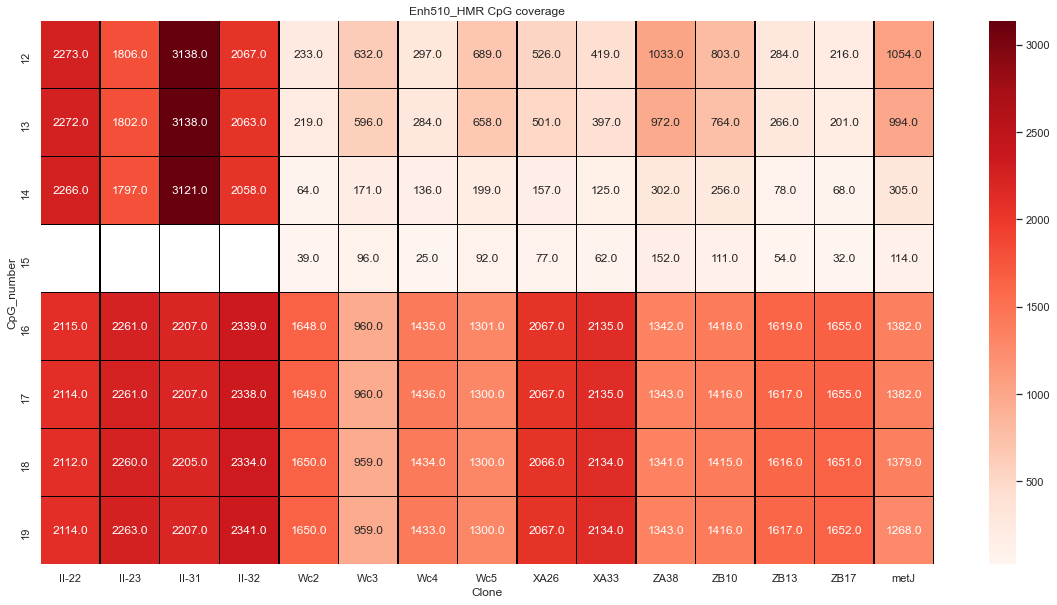

In [ ]:
# Visualize the coverage to check for data availability and quality
sns.set(style='white')
plt.figure(figsize=(20, 10))
plt.title('Enh510_HMR CpG coverage')
sns.heatmap(Enh510_HMR_pivot, mask=Enh510_HMR_pivot.isnull(), annot=True,
            fmt='0000', linewidths=0.5, linecolor='black', cmap="Reds")

In [ ]:
# Remove the data from non-relevant clones
Enh510_HMR_fig = Enh510_HMR[~Enh510_HMR.Clone.isin(['metJ', 'XA26', 'XA33'])].copy()

([<matplotlib.axis.XTick at 0x7fe9aa5c70a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

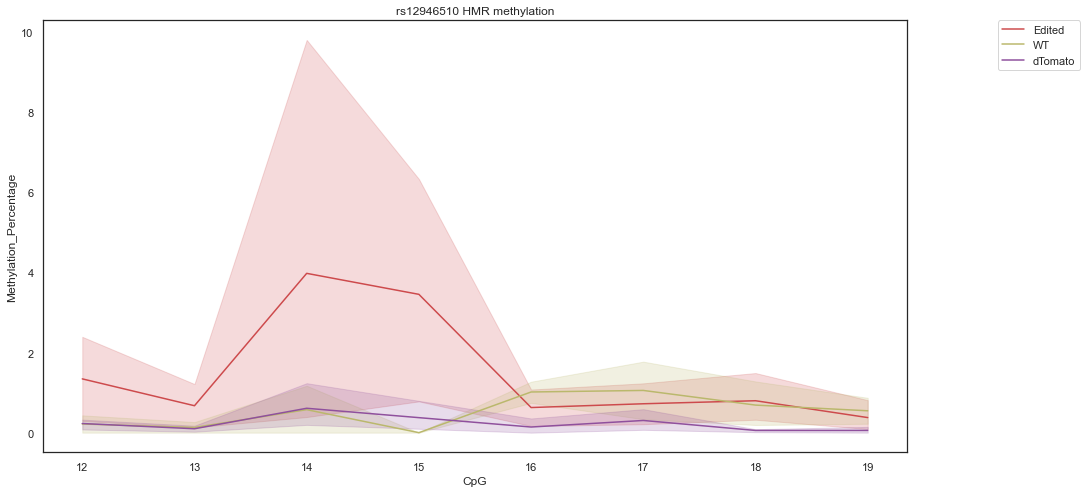

In [ ]:
# Visualize and compare methylation levels at the Enh510 HMR of parental
# cell line (WT), first editing step (dTomato), and fully edited clones (Edited).

# Lines represent average across clones.
# Transparent color bands represent standard deviation.

f2 = plt.figure(figsize=(12,6))
a2 = f2.add_axes([0, 0, 1, 1])
sns.set_theme(style="whitegrid", palette=[c3[0],c3[2],c3[1]])
sns.lineplot(x="CpG_number", y="Methylation_Percentage",
             hue="Group", data=Enh510_HMR_fig)
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)
a2.set(title='rs12946510 HMR methylation', xlabel='CpG')
plt.xticks(range(12,20))
#f2.savefig('Enh510_Methylation.png', dpi=300, bbox_inches='tight', edgecolor='white')

**Here, methylation levels are also very low and the values for fully edited clones are no bigger than for the parental line. DNA methylation in the hypomethylated region overlapping the editing site can not be responsible for the IKZF3 expression drop.**

### IKZF3 3'-UTR HMR


In [ ]:
# Locate the CpGs (this region contains only HMR CpGs)
IKZF3_HMR_CpG = sorted(list(IKZF3_HMR.End.unique()))
IKZF3_HMR_number = pd.DataFrame({'End':IKZF3_HMR_CpG,
    'CpG_number':range(1,(len(IKZF3_HMR_CpG)+1))})
IKZF3_HMR_number

,End,CpG_number
0,39757931,1
1,39758037,2
2,39758096,3
3,39758132,4
4,39758385,5
5,39758475,6
6,39758513,7
7,39758628,8
8,39758680,9
9,39758700,10


<AxesSubplot:title={'center':'IKZF3 HMR CpG coverage'}, xlabel='Clone', ylabel='CpG_number'>

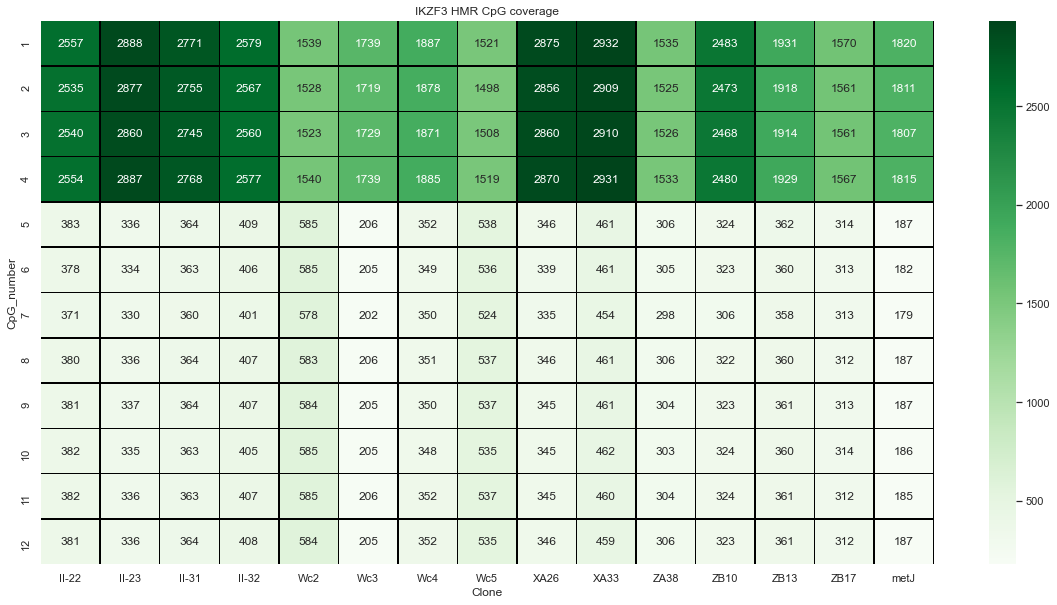

In [ ]:
# Check the sequencing coverage at each CpG in each clone
IKZF3_HMR = IKZF3_HMR.merge(IKZF3_HMR_number, how='left', on='End')
IKZF3_HMR_pivot = IKZF3_HMR.pivot(index='CpG_number', columns='Clone',
    values='total_count')

# Visualize the coverage to check for data availability and quality
sns.set(style='white')
plt.figure(figsize=(20, 10))
plt.title('IKZF3 HMR CpG coverage')
sns.heatmap(IKZF3_HMR_pivot, mask=IKZF3_HMR_pivot.isnull(), annot=True,
            fmt='0000', linewidths=0.5, linecolor='black', cmap="Greens")

In [ ]:
# Remove the data from the non-relevant clones
IKZF3_HMR_fig = IKZF3_HMR[~IKZF3_HMR.Clone.isin(['metJ', 'XA26', 'XA33'])].copy()

In [ ]:
IKZF3_HMR_fig.head()

,Chromosome,Start,End,Methylation_Percentage,Count_Methylated,Count_Unmethylated,total_count,Clone,Group,IKZF3,CpG_number
0,17,39757931,39757931,73.060942,2110,778,2888,II-23,dTomato,0.330047,1
1,17,39758037,39758037,72.471324,2085,792,2877,II-23,dTomato,0.330047,2
2,17,39758096,39758096,33.356643,954,1906,2860,II-23,dTomato,0.330047,3
3,17,39758132,39758132,20.401801,589,2298,2887,II-23,dTomato,0.330047,4
4,17,39758385,39758385,22.321429,75,261,336,II-23,dTomato,0.330047,5


In [ ]:
# Add external data on primaty T-cell methylation
cd4 = pd.read_csv('CD4_T_17_limited_final.csv')
cd4.rename(columns={'chrom':'Chromosome','pos':'End','mean':'Methylation_mean'},
           inplace=True)
cd4 = cd4.merge(IKZF3_HMR_number, how='left', on='End')
cd4.head()

,Chromosome,End,Methylation_mean,SD,CpG_number
0,17,39753836,1.458008,2.571020,NaN
1,17,39753845,0.475653,1.342731,NaN
2,17,39753856,0.703252,1.620168,NaN
3,17,39753866,1.335519,2.208907,NaN
4,17,39753878,0.309388,1.074209,NaN


In [ ]:
cd4_ROI = cd4[~cd4.CpG_number.isna()].copy()
cd4_ROI['Group']='Primary_CD4'
cd4_ROI

,Chromosome,End,Methylation_mean,SD,CpG_number,Group
191,17,39757931,24.794615,9.687037,1.0,Primary_CD4
192,17,39758037,58.961970,14.572274,2.0,Primary_CD4
193,17,39758096,13.084054,7.474252,3.0,Primary_CD4
194,17,39758132,12.239814,5.976241,4.0,Primary_CD4
195,17,39758385,57.979203,26.762241,5.0,Primary_CD4
196,17,39758475,62.382224,16.537889,6.0,Primary_CD4
197,17,39758513,81.422318,19.145571,7.0,Primary_CD4
198,17,39758628,82.996932,12.311205,8.0,Primary_CD4
199,17,39758680,79.752730,11.730094,9.0,Primary_CD4
200,17,39758700,72.897303,12.636686,10.0,Primary_CD4


In [ ]:
# Compare the average methylation across all CpGs in the region among cell clones
IK3mean = IKZF3_HMR_fig.groupby(by=['Group','Clone'],
    as_index=False)['Methylation_Percentage'].mean()
IK3mean

,Group,Clone,Methylation_Percentage
0,Edited,ZA38,75.319533
1,Edited,ZB10,54.795820
2,Edited,ZB13,61.989514
3,Edited,ZB17,65.861577
4,WT,Wc2,51.953400
5,WT,Wc3,49.460747
6,WT,Wc4,53.820687
7,WT,Wc5,48.411470
8,dTomato,II-22,69.350681
9,dTomato,II-23,67.325077


In [ ]:
# Use statistical criterion suitable for comparison of more than 2 groups
stats.kruskal(IK3mean[IK3mean.Group=='Edited'].Methylation_Percentage,
              IK3mean[IK3mean.Group=='WT'].Methylation_Percentage,
              IK3mean[IK3mean.Group=='dTomato'].Methylation_Percentage)

KruskalResult(statistic=8.0, pvalue=0.018315638888734182)

In [ ]:
# There is a statistically significant difference in the average methylation levels.
# Compare the fully edited and parent cells.
stats.mannwhitneyu(x=IK3mean[IK3mean.Group=='Edited'].Methylation_Percentage,
                   y=IK3mean[IK3mean.Group=='WT'].Methylation_Percentage,
                   alternative='greater')

MannwhitneyuResult(statistic=16.0, pvalue=0.015191410988288745)

In [ ]:
# Calculate the ratio
edited_avg = IK3mean[IK3mean.Group=='Edited'].Methylation_Percentage.mean()
wt_avg = IK3mean[IK3mean.Group=='WT'].Methylation_Percentage.mean()
edited_avg / wt_avg

1.2667376726181998

In [ ]:
# Look at the individual CpG level
CpG_p_vals = {}

for i in list(IKZF3_HMR.CpG_number.unique()):
    edited_df = IKZF3_HMR[(IKZF3_HMR.Group == 'Edited')&(IKZF3_HMR.CpG_number==i)]
    edited_meth_ser = edited_df.Methylation_Percentage
    wt_df = IKZF3_HMR[(IKZF3_HMR.Group=='WT')&(IKZF3_HMR.CpG_number==i)]
    wt_meth_ser = wt_df.Methylation_Percentage
    U=stats.mannwhitneyu(x=edited_meth_ser, y=wt_meth_ser, alternative='greater')
    CpG_p_vals[i] = U

CpG_p_vals

{1: MannwhitneyuResult(statistic=21.0, pvalue=0.03497717929000515),
 2: MannwhitneyuResult(statistic=24.0, pvalue=0.007107019434541023),
 3: MannwhitneyuResult(statistic=20.0, pvalue=0.05490970440761861),
 4: MannwhitneyuResult(statistic=24.0, pvalue=0.007107019434541023),
 5: MannwhitneyuResult(statistic=24.0, pvalue=0.007107019434541023),
 6: MannwhitneyuResult(statistic=21.0, pvalue=0.03497717929000515),
 7: MannwhitneyuResult(statistic=18.0, pvalue=0.12047733435078506),
 8: MannwhitneyuResult(statistic=4.0, pvalue=0.9650228207099949),
 9: MannwhitneyuResult(statistic=15.0, pvalue=0.29701617029952077),
 10: MannwhitneyuResult(statistic=9.0, pvalue=0.772227453105335),
 11: MannwhitneyuResult(statistic=24.0, pvalue=0.007107019434541023),
 12: MannwhitneyuResult(statistic=12.0, pvalue=0.5424469827897471)}

Although methylation differences at some CpGs look pretty significant, we should keep in mind the multiple comparisons problem. None of these p-values is lower than the Bonferroni-corrected significance level of 0.004.

<ipython-input-235-9ff52276e826>:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f2.tight_layout()


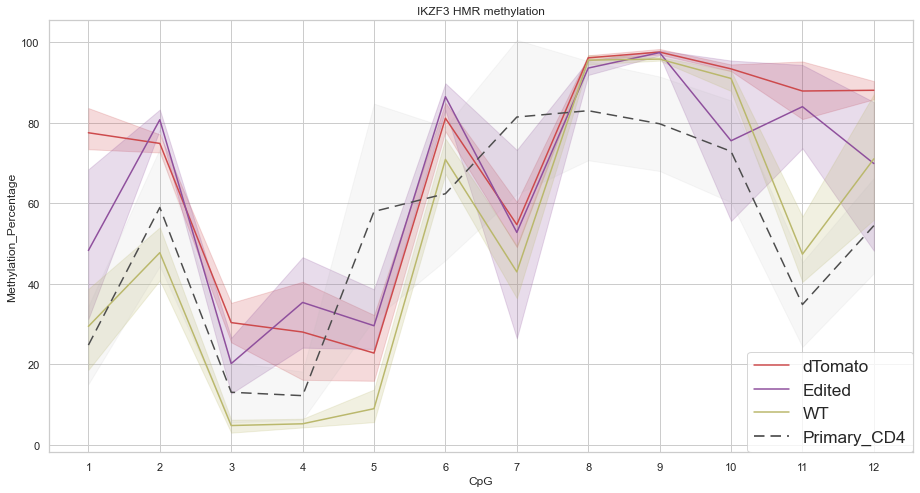

In [ ]:
# Visualize and compare methylation levels at the IKZF3 3'-UTR HMR of
# parental cell line (WT), first editing step (dTomato),
# fully edited clones (Edited), and primary CD4 T cells (Primary_CD4).

# Lines represent average across clones.
# Transparent color bands represent standard deviation.

f2 = plt.figure(figsize=(12,6))
a2 = f2.add_axes([0, 0, 1, 1])
sns.set_theme(style="whitegrid", palette=c3)
sns.lineplot(x="CpG_number", y="Methylation_Percentage",
             hue="Group", data=IKZF3_HMR_fig)
sns.lineplot(x="CpG_number", y='Methylation_mean', style='Group',
             data=cd4_ROI, ax=a2, color=".3", dashes=[(7,4)])
a2.set(title='IKZF3 HMR methylation', xlabel='CpG')
a2.fill_between(x=cd4_ROI.CpG_number, y1=(cd4_ROI.Methylation_mean-cd4_ROI.SD),
                y2=(cd4_ROI.Methylation_mean+cd4_ROI.SD), color=".7", alpha=0.1)
plt.legend(loc='lower right', borderaxespad=0, fontsize='x-large')
plt.xticks(range(1,13))
f2.tight_layout()
#f2.savefig('IKZF3_HMR_Methylation_olive.png', dpi=300, bbox_inches='tight', edgecolor='white')

**Average methylation of this region is 30% percent higher in fully edited clones compared to parental line clones. Methylation levels and their difference between experimental groups largely vary across individual CpGs. The most significant increase in methylation level is observed at CpGs ## 2, 4, 5, and 11. Methylation profile of the wild-type clones is very similar to primary cells, except for CpGs ## 5 and 7.**

## Correlation between IKZF3 3'-UTR HMR methylation level and IKZF3 gene expression

Average methylation across all CpGs

In [ ]:
# We consider each clone an individual datapoint because they have
# very different expression and methylation levels
IK3_HMR_no_metJ = IKZF3_HMR[IKZF3_HMR.Clone!='metJ'].copy()
IK3_HMR_no_metJ_mean = IK3_HMR_no_metJ.groupby(by=['Group','Clone','IKZF3'],
    as_index=False)['Methylation_Percentage'].mean()
IK3_HMR_no_metJ_mean

,Group,Clone,IKZF3,Methylation_Percentage
0,Edited,XA26,0.297339,63.127392
1,Edited,XA33,0.000762,62.112933
2,Edited,ZA38,0.004324,75.319533
3,Edited,ZB10,0.000467,54.795820
4,Edited,ZB13,0.002788,61.989514
5,Edited,ZB17,0.017351,65.861577
6,WT,Wc2,0.830785,51.953400
7,WT,Wc3,1.518355,49.460747
8,WT,Wc4,0.058947,53.820687
9,WT,Wc5,1.591913,48.411470


<AxesSubplot:xlabel='Methylation_Percentage', ylabel='IKZF3'>

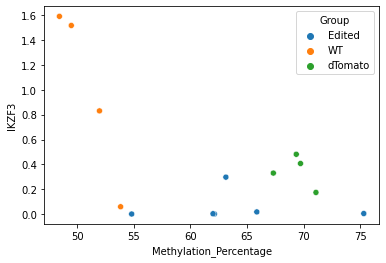

In [ ]:
# Take a general look at the distribution
sns.scatterplot(x='Methylation_Percentage', y='IKZF3',
                data=IK3_HMR_no_metJ_mean, hue='Group')

Individual CpG level

In [ ]:
# Exclude intermediate editing stage clones, as they contain large DNA insert
IK3_HMR_no_metJ_no_Tom = IKZF3_HMR[(IKZF3_HMR.Clone != 'metJ')&\
    (IKZF3_HMR.Group != 'dTomato')].copy()

# Log transformation due to heteroscedasticity of the gene expression data
IK3_HMR_no_metJ_no_Tom_log = IK3_HMR_no_metJ_no_Tom.copy()
IK3_HMR_no_metJ_no_Tom_log['IK3_log'] = numpy.log10(IK3_HMR_no_metJ_no_Tom_log.IKZF3)
IK3_HMR_no_metJ_no_Tom_log.head()

,Chromosome,Start,End,Methylation_Percentage,Count_Methylated,Count_Unmethylated,total_count,Clone,Group,IKZF3,CpG_number,IK3_log
12,17,39757931,39757931,44.031378,1291,1641,2932,XA33,Edited,0.000762,1,-3.118045
13,17,39758037,39758037,63.698866,1853,1056,2909,XA33,Edited,0.000762,2,-3.118045
14,17,39758096,39758096,0.618557,18,2892,2910,XA33,Edited,0.000762,3,-3.118045
15,17,39758132,39758132,21.664961,635,2296,2931,XA33,Edited,0.000762,4,-3.118045
16,17,39758385,39758385,22.993492,106,355,461,XA33,Edited,0.000762,5,-3.118045


In [ ]:
# Calculate Pearson correlation coefficients for each CpG and estimate its statistical significance
# (null hypothesis is that the slope is zero, Wald Test with t-distribution of the test statistic)
p_vals = {}
r2_vals = {}
for i in range(1,13):
    slope, intercept, r_value, p_value, std_err=stats.linregress(
        x=IK3_HMR_no_metJ_no_Tom_log[IK3_HMR_no_metJ_no_Tom_log.CpG_number==i].IK3_log,
        y=IK3_HMR_no_metJ_no_Tom_log[IK3_HMR_no_metJ_no_Tom_log.CpG_number==i].Methylation_Percentage)
    p_vals[i] = p_value
    r2_vals[i] = r_value**2

In [ ]:
# Find statistically significant correlations using Bonferroni correction for multiple testing
alpha_Bon = 0.05/12 #0.0042
sign_df = pd.DataFrame({'CpG':p_vals.keys(), 'p_value':p_vals.values()})
sign_df['is_significant'] = sign_df.p_value <= alpha_Bon
sign_df[sign_df.is_significant == True]

,CpG,p_value,is_significant
5,6,0.000078,True


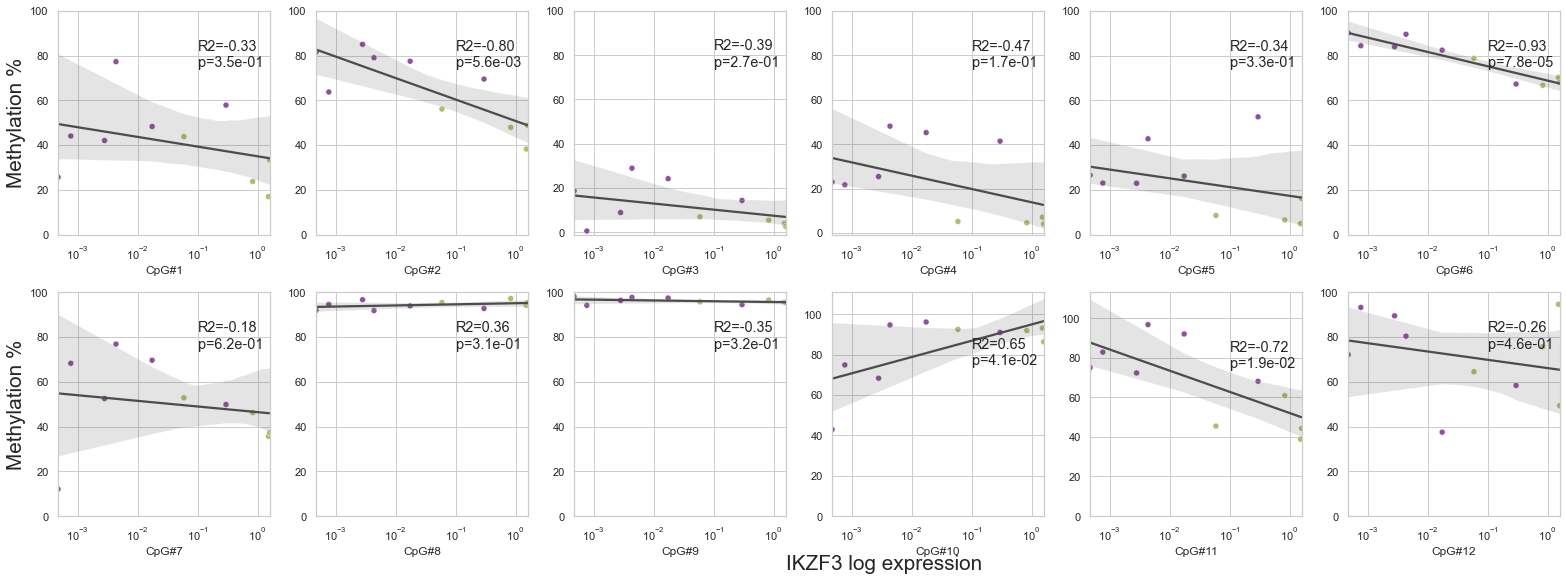

In [ ]:
# Plot the regression lines for each CpG
f, axs = plt.subplots(2,6,figsize=(22,8))
sns.set_theme(style="whitegrid", palette=c5)
for i in [0,1]:
    for j in range(6):
        d = IK3_HMR_no_metJ_no_Tom[IK3_HMR_no_metJ_no_Tom.CpG_number==(6*i+j+1)]
        sns.scatterplot(y='Methylation_Percentage', x='IKZF3',
                        data=d, hue='Group', ax=axs[i,j], legend=False)
        sns.regplot(x='IKZF3', y='Methylation_Percentage',
                    data=d, logx=True, scatter=False, color=".3", ax=axs[i,j])
        axs[i,j].set(xscale='log', xlabel='CpG#' + str(i*6+j+1), ylabel='')
        axs[i,j].text(x=0.1, y=75, s="R2={0:.2f}\np={1:.1e}".\
                      format(r2_vals[(6*i+j+1)],p_vals[(6*i+j+1)]),
                      size='large')

plt.setp(axs, yticks=range(0,101,20))
axs[0,0].set_ylabel('Methylation %', size='xx-large')
axs[1,0].set_ylabel('Methylation %', size='xx-large')
f.text(x=0.5, y=0, s='IKZF3 log expression', size='xx-large')
f.tight_layout()
#f.savefig('IKZF3_versus_meth_no_Tom_reg_olive.png', dpi=300, bbox_inches='tight', edgecolor='white')

**Individual CpGs in the IKZF3 3-'UTR HMR show very different patterns. Methylation at the CpG #6 shows the most significant correlation with the IKZF3 mRNA level, while the slope is biggest for CpGs ## 2 and 11.**

## Conclusion
DNA methylation levels changed indeed after the genome editing procedure. Somewhat surprisingly, the area of the cut site itself was not affected, but the hypomethylated region in the 3'-untranslated region of the IKZF3 gene had 30% higher methylation level (averaged across all CpGs). Methylation level at one of the CpGs in this region shows strong and significant correlation with the IKZF3 expression. This can be an example of the ["CpG traffic lights" fenomenon](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-018-5387-1) described for promoter and gene body methylation, but theoretically applicable to other regulatory regions.